In [1]:
sealed trait Nat
final object Zero extends Nat
final case class Suc(n: Nat) extends Nat
sealed trait List[+A]
final object Nil extends List[Nothing]
final case class Cons[A](head: A, tail: List[A]) extends List[A]

defined trait Nat
defined object Zero
defined class Suc
defined trait List
defined object Nil
defined class Cons

In [2]:
def length[A]: List[A] => Int = {
    case Nil => 0
    case Cons(h, t) => 1 + length(t)
} 

defined function length

In [3]:
sealed trait Ring 
case object Zero extends Ring
case object One extends Ring
case class Elem(x: Int) extends Ring
case class Add(x: Ring, y: Ring) extends Ring
case class Mult(x: Ring, y: Ring) extends Ring


defined trait Ring
defined object Zero
defined object One
defined class Elem
defined class Add
defined class Mult

In [4]:
def toInt: Ring => Int = {
    case Zero => 0
    case One => 1
    case Elem(x) => x
    case Add(x, y) => toInt(x) + toInt(y)
    case Mult(x, y) => toInt(x) * toInt(y)
}

defined function toInt

In [5]:
sealed trait RingF[+A]
case object Zero extends RingF[Nothing]
case object One extends RingF[Nothing]
case class Elem(x: Int) extends RingF[Nothing]
case class Add[A](x: A, y: A) extends RingF[A]
case class Mult[A](x:A, y: A) extends RingF[A]



defined trait RingF
defined object Zero
defined object One
defined class Elem
defined class Add
defined class Mult

In [6]:
val expresion1 = Mult(Elem(4), Add(Elem(3), One))

expresion1: Mult[Product with Serializable with RingF[Product with Serializable with RingF[Nothing]]] = Mult(Elem(4), Add(Elem(3), One))

In [7]:
def evalToInt: RingF[Int] => Int = {
    x => x match {
        case Zero => 0
        case One => 1
        case Elem(x) => x
        case Add(x, y) => x + y
        case Mult(x, y) => x * y
    }
}



defined function evalToInt

In [8]:
trait Functor[F[_]] {
    def map[A,B](f: A => B): F[A] => F[B]
}

implicit val ringFunctor = new Functor[RingF] {
    override def map[A, B](f: A => B): RingF[A] => RingF[B] = {
        case Zero => Zero
        case One => One
        case Elem(x) => Elem(x)
        case Add(x, y) => Add(f(x), f(y))
        case Mult(x, y) => Mult(f(x), f(y))
    }
}

defined trait Functor
ringFunctor: AnyRef with Functor[RingF] = ammonite.$sess.cmd7$Helper$$anon$1@c00ce88

In [9]:
def liftInt: RingF[RingF[Int]] => RingF[Int] = {
    ringFunctor.map(evalToInt)
}

defined function liftInt

In [10]:
case class Fix[F[_]](value: F[Fix[F]] )
object Fix {
  def fix[F[_]](ff: F[Fix[F]]): Fix[F] = new Fix[F](ff)
  def unfix[F[_]]: Fix[F] => F[Fix[F]] = f => f.value
}

defined class Fix
defined object Fix

In [11]:
type Ring = Fix[RingF]
val zero = Fix[RingF](Zero)
val one =  Fix[RingF](One)
def elem: Int  => Ring = x => Fix[RingF](Elem(x))
def add: (Ring, Ring) => Ring = (x, y) =>  Fix[RingF](Add(x, y))
def mult: (Ring, Ring) => Ring = (x, y) =>  Fix[RingF](Mult(x, y))

defined type Ring
zero: Fix[RingF] = Fix(Zero)
one: Fix[RingF] = Fix(One)
defined function elem
defined function add
defined function mult

In [12]:
val s = add(elem(7), elem(7))
val exp1 = mult(elem(4), add(elem(3), one))

s: Ring = Fix(Add(Fix(Elem(7)), Fix(Elem(7))))
exp1: Ring = Fix(Mult(Fix(Elem(4)), Fix(Add(Fix(Elem(3)), Fix(One)))))

In [13]:
def cata: Fix[RingF] => Int = {
    x => evalToInt(ringFunctor.map(cata)(Fix.unfix(x)))
}


defined function cata

In [14]:
cata(exp1)

res13: Int = 16

In [15]:
def cata[F[_], A](alg: F[A] => A)(implicit F: Functor[F]): Fix[F] => A = {
    x => alg(F.map(cata(alg))(Fix.unfix(x)))
}

defined function cata

In [16]:
cata(evalToInt)(ringFunctor)(exp1)

res15: Int = 16

In [17]:
/**h
Repasar esto para que funcione
**/
sealed trait ListF[+A, +B]
sealed trait List[+A] extends ListF[A, Fix[List]]
final object Nil extends ListF[Nothing, Nothing]
final case class Cons[A, B](head: A, tail: B) extends ListF[A, B]

defined trait ListF
defined trait List
defined object Nil
defined class Cons

In [18]:
def findDivisorsOf(r: Int): RingF[Int] = {
    def loop(n: Int): RingF[Int] = {
        n match {
            case 0 => Zero
            case 1 => One
            case x => 
                if (x >= r) Elem(x)
                else if (r%x == 0) Mult(r/x, x) 
                else loop(n+1)
        }
    }
    loop(2)
}

defined function findDivisorsOf

In [19]:
findDivisorsOf(6)
findDivisorsOf(12)

res18_0: RingF[Int] = Mult(3, 2)
res18_1: RingF[Int] = Mult(6, 2)

In [20]:
def f1: RingF[Int] => RingF[RingF[Int]] = ringFunctor.map(findDivisorsOf)
def find: Int => RingF[RingF[Int]] = {
    x => f1(findDivisorsOf(x))
}

defined function f1
defined function find

In [21]:
find(8)

res20: RingF[RingF[Int]] = Mult(Mult(2, 2), Elem(2))

In [22]:
def ana[F[_], A](coalg: A => F[A])(implicit F: Functor[F]): A => Fix[F] = {
    x => Fix((F.map(ana(coalg))(coalg(x))))
}

defined function ana

In [23]:
val expression3 = ana(findDivisorsOf)(ringFunctor)(12)

expression3: Fix[RingF] = Fix(
  Mult(Fix(Mult(Fix(Elem(3)), Fix(Elem(2)))), Fix(Elem(2)))
)

In [24]:
def evalToStr: RingF[String] => String = {
    x => x match {
        case Zero => "0"
        case One => "1"
        case Elem(x) => x.toString
        case Add(x, y) => x.toString + " + " + y.toString
        case Mult(x, y) => x.toString + " * " + y.toString
    }
}

defined function evalToStr

In [25]:
cata(evalToStr)(ringFunctor)(ana(findDivisorsOf)(ringFunctor)(12))

res24: String = "3 * 2 * 2"

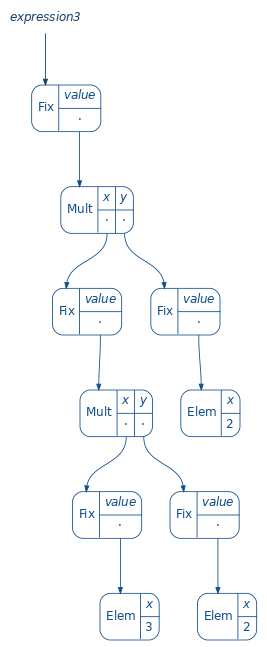

import $ivy.$                                



In [26]:
import $ivy.`io.github.stanch::reftree:1.3.0`

{{
  import reftree.render._, reftree.diagram._
  import reftree.contrib.SimplifiedInstances.string
  val renderer = Renderer(renderingOptions = RenderingOptions(density = 60))
    
  renderer.render("example5", Diagram.sourceCodeCaption(expression3))
}}
Image.fromFile("example5.png")

In [27]:
sealed trait ListF[+A] 
case object NilF extends ListF[Nothing]
case class ConsF[A](head: String, tail: A) extends ListF[A]

defined trait ListF
defined object NilF
defined class ConsF

In [28]:
val listOfStringFunctor = new Functor[ListF] {
 override def map[A, B](f: A => B): ListF[A] => ListF[B] = {
     case NilF => NilF
     case ConsF(h, t) => ConsF(h, f(t))
 }   
}

listOfStringFunctor: AnyRef with Functor[ListF] = ammonite.$sess.cmd27$Helper$$anon$1@7991c2e

In [29]:
type ListString = Fix[ListF]
val nil = Fix[ListF](NilF)
def cons : (String, ListString) => ListString = (h, t) =>  Fix[ListF](ConsF(h, t))

defined type ListString
nil: Fix[ListF] = Fix(NilF)
defined function cons

In [30]:
val fixL1 = cons("a", cons("b", cons("c", nil)))

fixL1: ListString = Fix(ConsF("a", Fix(ConsF("b", Fix(ConsF("c", Fix(NilF)))))))

In [31]:
def length: ListF[Int] => Int = {
    case NilF => 0
    case ConsF(h, t) => t + 1
}

cata(length)(listOfStringFunctor)(fixL1)

defined function length
res30_1: Int = 3

In [32]:
val l1 = List("a", "b", "c")

l1: collection.immutable.List[String] = List("a", "b", "c")

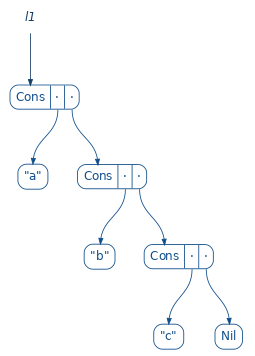

import $ivy.$                                



In [33]:
import $ivy.`io.github.stanch::reftree:1.3.0`

{{
  import reftree.render._, reftree.diagram._
  import reftree.contrib.SimplifiedInstances.string
  val renderer = Renderer(renderingOptions = RenderingOptions(density = 60))
    
  renderer.render("example7", Diagram.sourceCodeCaption(l1))
}}
Image.fromFile("example7.png")

In [ ]:
l1.foldLeft(0)((h, t) => h + 1)

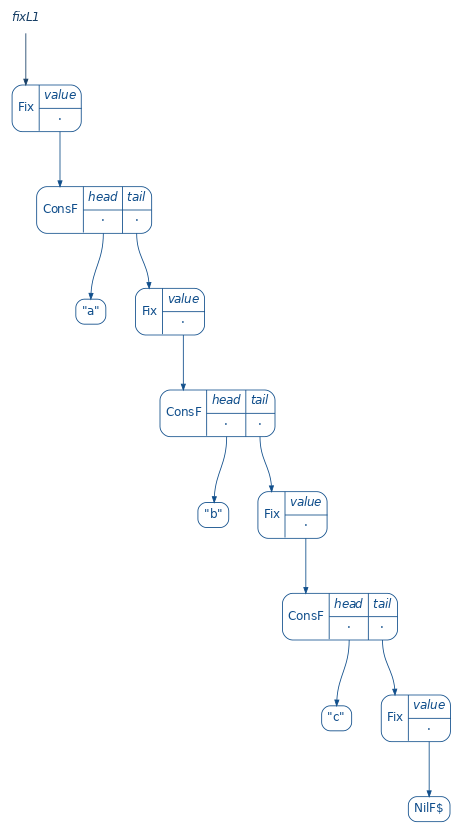

import $ivy.$                                



In [34]:
import $ivy.`io.github.stanch::reftree:1.3.0`

{{
  import reftree.render._, reftree.diagram._
  import reftree.contrib.SimplifiedInstances.string
  val renderer = Renderer(renderingOptions = RenderingOptions(density = 60))
    
  renderer.render("example8", Diagram.sourceCodeCaption(fixL1))
}}
Image.fromFile("example8.png")

In [35]:
def myFoldLeft[A](baseValue: A)(evaluator: (String, A) => A)(l: ListString): A = {
    def alg: ListF[A] => A = {
        case NilF => baseValue
        case ConsF(h, t) => evaluator(h, t)
        }
    cata(alg)(listOfStringFunctor)(l)

}

defined function myFoldLeft

In [36]:
myFoldLeft(0)((x, y) => y + 1)(fixL1)

res35: Int = 3

In [37]:
def hylo[A, B, F[_]](ana: A => Fix[F])(cata: Fix[F] => B): A => B = {
    x => cata(ana(x))
}


defined function hylo